<h3><center>Clase ejercicios - IMA539.</center></h3>
<center>Camilo Calfucoy, Fernanda Garrido.</center>

<center>4 de Diciembre del 2023.</center>



ANTES DE COMENZAR SE DEBE INSTALAR LA SIGUIENTE COMPONENTE (en el entorno ima539):

pip install tqdm

### La base de datos.
El conjunto de datos Custom-FashionMNIST contiene un total de 70.000 imágenes en escala de grises de tamaño 28x28 píxeles cada una. Las imágenes provienen de artículos publicados en Zalando se distinguen 10 clases:   

| Clase | Etiqueta | Clase | Etiqueta  |
|-------|----------|-------|-----------|
| 0     | Polera   | 5     | Sandalia  |
| 1     | Pantalón | 6     | Camisa    |
| 2     | Polerón  | 7     | Zapatilla |
| 3     | Vestido  | 8     | Bolso     |
| 4     | Abrigo   | 9     | Botas     |

Este dataset es importante en la literatura pues se diseñó para tomar el puesto del MNIST original (clasificación de números escritos a mano). Normalmente, su carga se puede automatizar en la mayoría de las librerías de ML como PyTorch o Tensorflow, sin embargo, Custom-FashionMNIST ha sido reordenado cuidadosamente de modo de hacerle el trabajo un poco más difícil:

El conjunto de datos se ha separado de modo que los elementos clasificados con un número 

- **Par**: Se encuentran separados en carpetas cuyo nombre es el número de la clase y cada archivo de imagen posee como nombre `image-id_A.jpg`, donde `A` es el identificador de la imagen. La única excepción a la regla son los elementos con clasificación bolso, en cuyo caso el nombre de la carpeta es un string. 
- **Impar**: Se encuentran todas agrupadas en un directorio de nombre `other` y el formato de los nombres de los archivos de imagen es `image-id_A-label-B.jpg`, donde `A` es el identificador de la imagen y `B` su clase.

**Los identificadores `A` de las imágenes son únicos, independientemente de su ubicación o clasificación.**

El siguiente diagrama muestra la distribución de los ficheros del conjunto de datos:
```
Custom-FashionMNIST
├── 0
│   ├── image-id_0.jpg
│   └── ...
├── 2
│   ├── image-id_5665.jpg
│   └── ...
├── 4
│   ├── image-id_1837.jpg
│   └── ...
├── 6
│   ├── image-id_31784.jpg
│   └── ...
├── bag
│   ├── image-id_18461.jpg
│   └── ...
└── other
    ├── image-id_6171-label_1.jpg
    └── ...
```

**Importante:** Como el sistema operativo en que este conjunto de datos fue armado es MacOS, carpetas con el nombre .DS_Store pueden ser encontradas dentro de algunos directorios, lo cual debe ser considerado en la lectura de los archivos.


### Ejercicio.
Realize un split train/val/test de la base de datos, luego, idee e instancie un modelo de CNN utilizando PyTorch. Entrene el modelo y determine si este presenta sobre-ajuste, bajo-ajuste. Finalmente, reporte Acc, TPR, FPR, K y MCC en el conjunto de testeo.

***
### Database creation

In [1]:
import os
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.FashionMNIST(root= '.', train= True,
                                                  transform= transform, download= True)
mnist_test_dataset = torchvision.datasets.FashionMNIST(root= '.', train= False,
                                                       transform= transform, download= False)

100%|██████████| 26421880/26421880 [00:18<00:00, 1397239.71it/s]


Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 121981.14it/s]


Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:07<00:00, 615402.40it/s]


Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2457857.37it/s]


Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



In [3]:
batch_size = 32
train_dl = DataLoader(mnist_train_dataset, batch_size= batch_size, shuffle= False)
test_dl = DataLoader(mnist_test_dataset, batch_size= batch_size, shuffle= False)

In [4]:
# ID of the image
image_id = 0

# Root dir
root = 'Custom-FashionMNIST'
if not os.path.exists(root):
    os.mkdir(root)

# For every batch
for dl in [train_dl, test_dl]:
    for imgs, labels in dl:
        for img, label in zip(imgs, labels):
            # Pair labels
            if label.item() in [1, 3, 5, 7, 9]:
                dir_name = os.path.join(root, 'other_labels')
                if not os.path.exists(dir_name):
                    os.makedirs(dir_name)
                image_file_name = os.path.join(dir_name, f'image-id_{str(image_id)}-label_{str(label.item())}.jpg')
            # Odd labels
            else:
                class_dir_name = 'bag' if label.item() == 8 else str(label.item())
                dir_name = os.path.join(root, class_dir_name)
                if not os.path.exists(dir_name):
                    os.makedirs(dir_name)
                image_file_name = os.path.join(dir_name, f'image-id_{str(image_id)}.jpg')
            #torchvision.utils.save_image(img, image_file_name)
            torchvision.transforms.ToPILImage()(img).save(image_file_name)
            image_id += 1

print(f'Images on the original dataset: {len(mnist_test_dataset) + len(mnist_train_dataset)}')
print(f'Images on the custom dataset: {image_id}')

***
### Librerías y útiles

In [5]:
# default
import os

# pip
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# torch
import torch
import torchvision
from torch import nn
#from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

***
### Vías de carga
1. **Dataloader**: Para esto, la base de datos debe contener una carpeta por clase con todos los elementos correspondientes a esa clase dentro. Dataloader cargará los elementos en batches y creará un diccionario que contiene el mapeo de las clases a entero. Una vez creado, es posible definir el tamaño del batch y automáticamente se administrarán los recursos para la creación de los batches en las llamadas
2. **Cargado de datos por batch**: Se debe implementar un script que permita cargar las muestras, es importante distinguirlo porque acá se tiene el cuidado de cargar únicamente los elementos del batch en memoria.
3. **Cargado de todos los datos**: Simplemente se leen todos los datos y luego se van utilizando en batches. Es la peor de todas pues no optimiza los recursos de la máqunia, lo que puede resultar en errores en una implementación con una cantidad elevada de datos.

Se implementará la segunda forma. Para esto, en primer lugar se crea un arreglo con las rutas de las imágenes y otro con sus clases

In [6]:
# Carpeta raiz de todo el dataset
root = 'Custom-FashionMNIST'

# Paths and labels
img_paths = []
img_class = []

# For every dir in root
for class_dir in os.listdir(root):
    # Do nothing when the dir name is .DS_Store
    if class_dir == '.DS_Store':
        continue
    # Path to dir in root
    class_dir_path = os.path.join(root, class_dir)

    # Get every element in the dir
    elems = [os.path.join(class_dir_path, x) 
                for x in os.listdir(class_dir_path) 
                if x != '.DS_Store']
    # Add image path
    img_paths.extend(elems)

    # -------------------------
    # Treatment for odd labels
    # -------------------------
    if class_dir == 'other_labels':
        img_class.extend([int(x[-5]) for x in elems])

    # -------------------------
    # Treatment for pair labels
    # -------------------------
    else:
        # Change bag to 8 class
        if class_dir == 'bag':
            img_class.extend([8 for _ in range(len(elems))])
        # Dir name to int
        else:
            img_class.extend([int(class_dir) for _ in range(len(elems))])

# Verificación
classes, counts = np.unique(img_class, return_counts= True)
print('class | counts')
print('--------------')
_ = [print('{:5n} | {:n}'.format(x, y)) for x, y in zip(classes, counts)]

class | counts
--------------
    0 | 7000
    1 | 7000
    2 | 7000
    3 | 7000
    4 | 7000
    5 | 7000
    6 | 7000
    7 | 7000
    8 | 7000
    9 | 7000


Con esto, es posible generar el split TVT. Aquí usaremos un truco, en vez de trabajar con las imágenes podríamos trabajar con sus rutas, pero hay una forma mejor aún, trabajar con los índices del arreglo de rutas!

In [7]:
img_path_idxs = list(range(len(img_paths)))

# Train+Validation / Test
X_train_val, X_test, y_train_val, y_test = train_test_split(img_path_idxs, img_class, test_size=0.1, random_state=42, stratify= img_class)

# Train / Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify= y_train_val)

print(f'Cantidad de elementos en:\n  Train: {len(X_train)}\n  Val:   {len(X_val)}\n  Test:  {len(X_test)}')
print(f'\nIndices repetidos entre Train/Test: {len(set(X_test).intersection(set(X_train)))}')
print(f'Indices repetidos entre Train/Val: {len(set(X_train).intersection(set(X_val)))}')
print(f'Indices repetidos entre Test/Val: {len(set(X_test).intersection(set(X_val)))}')

Cantidad de elementos en:
  Train: 50400
  Val:   12600
  Test:  7000

Indices repetidos entre Train/Test: 0
Indices repetidos entre Train/Val: 0
Indices repetidos entre Test/Val: 0


Ahora es necesario cargar los batches, lo ideal sería hacerlo de la forma que menos recursos utilice. Para esto, es posible utilizar generadores de Python

In [8]:
# Generador
def getBatch(paths, labels, index_split, batch_size):
    paths, labels = np.array(paths), np.array(labels)
    l = len(index_split)
    for ndx in range(0, l, batch_size):
        idxs = index_split[ndx:min(ndx + batch_size, l)]
        imgs = torch.stack([torchvision.io.read_image(x) for x in paths[idxs]])
        labels = torch.tensor(labels[idxs],dtype=torch.long)
        yield imgs, labels

Aunque es más cómodo crear una clase dataset customizada y luego enviarla a un dataloader

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, labels, split_indexes):
        # Indexes of the split
        self.split_indexes = split_indexes
        # Only elements of that split
        self.paths = np.array(paths)[split_indexes]
        self.labels = np.array(labels)[split_indexes]

    def __len__(self):
        return len(self.split_indexes)

    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.paths[idx]).float()
        label = torch.tensor(self.labels[idx],dtype=torch.long)
        return image, label

In [10]:
# Datasets
train_ds = CustomImageDataset(img_paths, img_class, X_train)
valid_ds = CustomImageDataset(img_paths, img_class, X_val)
test_ds = CustomImageDataset(img_paths, img_class, X_test)

# DataLoaders
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle= True)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, shuffle= False)

### Implementación del modelo.

In [11]:
# Constructor
model = nn.Sequential()

# Conv -> ReLU -> MaxPooling
model.add_module('conv1', nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= 5, padding= 2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size= 2))

# Conv -> ReLU -> MaxPooling
model.add_module('conv2', nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 5, padding= 2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size= 2))

# Flatten
model.add_module('flatten', nn.Flatten())

# Full Connected -> ReLU -> Dropout
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= .5))

# Full Connected
model.add_module('fc2', nn.Linear(1024, 10))
#model.add_module('soft', nn.Softmax(dim=10))

In [12]:
# Selección de dispositivo
if torch.cuda.is_available(): 
    processing_unit = 'cuda'
elif torch.backends.mps.is_built():
    processing_unit = 'mps'
else:
    processing_unit = 'cpu'
device = torch.device(processing_unit)

# Pesos del modelo al dispositivo
model.to(device)

print(f"You're using: {device} as device.")

You're using: cuda as device.


### Entrenamiento

In [13]:
# Función de costo: CrossEntropy
loss_fn = nn.CrossEntropyLoss()

# Optimizador: ADAM
optimizer = torch.optim.Adam(model.parameters(), lr= .001)

Función de entrenamiento

In [14]:
def train(model, num_epochs, train_dl, valid_dl, device):
    # Perdida y exactitud en entrenamiento
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
    # Perdida y exactitud en validación
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)

    # Por cada época
    for epoch in range(num_epochs):
        # Modelo en modo entrenamiento
        model.train()
        with tqdm(train_dl, unit="batch") as tepoch:
            # Por batch en el conjunto de entrenamiento
            for x_batch, y_batch in tepoch:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                # Predicciones del modelo
                pred = model(x_batch)
                # Pérdida del modelo
                loss = loss_fn(pred, y_batch)
                # Paso hacia atrás
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Guarda pérdida en entrenamiento
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                # Cantidad de muestras predichas correctamente
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                # Guarda exactitud
                accuracy_hist_train[epoch] += is_correct.sum()
                tepoch.set_postfix(batch_loss= loss.item(),
                                   batch_accuracy= 100. * is_correct.sum().item() / y_batch.size(0))
            # Promedio por época en todos los batches
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # Modelo en modo evaluación
        model.eval()
        with tqdm(valid_dl, unit="batch") as vepoch:
            # Pesos congelados
            with torch.no_grad():
                # Por batch en el conjunto de validación
                for x_batch, y_batch in vepoch:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    # Predicciones
                    pred = model(x_batch)
                    # Pérdida
                    loss = loss_fn(pred, y_batch)
                    # Guarda pérdia en validación
                    loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                    # Cantidad de muestras predichas correctamente
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                    # Guarda exactitud
                    accuracy_hist_valid[epoch] += is_correct.sum()
                    vepoch.set_postfix(batch_loss= loss.item(),
                                       batch_accuracy= 100. * is_correct.sum().item() / y_batch.size(0))
            # Promedio por época en todos los batches
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

Entrenamiento

In [16]:
torch.manual_seed(1)
num_epochs = 4
hist = train(model, num_epochs, train_dl, valid_dl, device)

  0%|          | 0/1575 [00:00<?, ?batch/s]

100%|██████████| 394/394 [00:04<00:00, 91.22batch/s, batch_accuracy=83.3, batch_loss=0.392] 


### Evaluación del modelo

Curvas de aprendizaje

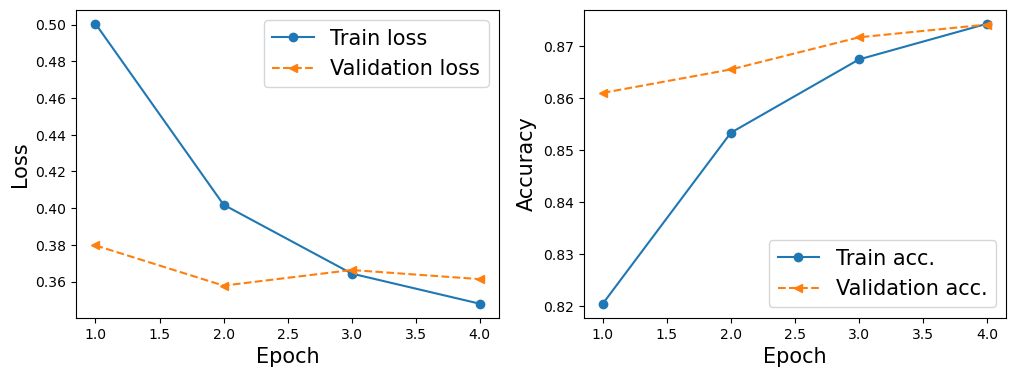

In [17]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize= (12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

Evaluación en testeo

In [18]:
# Imagenes en testeo
test_imgs = torch.stack([test_ds[i][0] for i in range(len(test_ds))]).to(device)
# Predicción
predictions = model(test_imgs)
del test_imgs
# Predicciones a categórica
test_pred_class = torch.argmax(predictions, dim= 1)
del predictions
# Etiqueta real
test_real_class = torch.stack([test_ds[i][1] for i in range(len(test_ds))]).to(device)

In [19]:
is_correct = (test_pred_class == test_real_class).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.8779


Subset de imágenes y su predicción

In [20]:
num_to_class = {0: 'Tshirt', 1: 'Trouser',
                2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal',
                6: 'Shirt', 7: 'Sneaker',
                8: 'Bag', 9: 'Boot',}

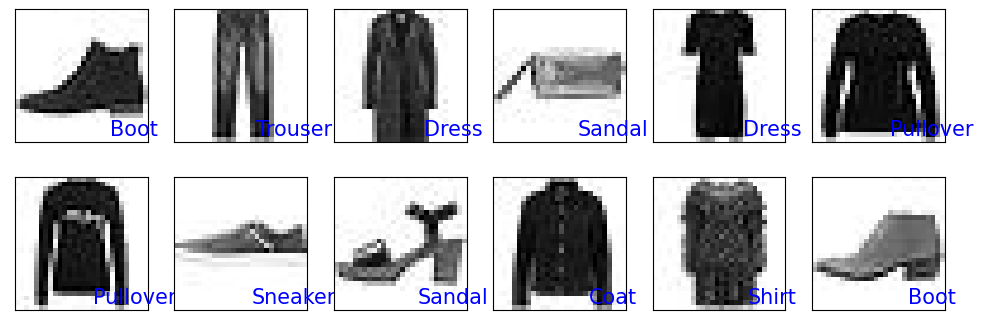

In [21]:
imgs = torch.stack([test_ds[i][0] for i in range(12)]).to(device)
preds = torch.argmax(model(imgs), dim= 1)
txt_class = [num_to_class[x.item()] for x in preds.cpu()]

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imgs[i][0].cpu(), cmap= 'gray_r')
    ax.text(.9, .1, txt_class[i], size= 15, color= 'blue',
            horizontalalignment= 'center', verticalalignment= 'center',
            transform= ax.transAxes)
plt.show()